In [1]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
# from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
# from mappings import *
from train_functions import *


#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)
train_data = rdkit2pyg(train_guac_mols[:32])


#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 

#! --- SET UP EXPERIMENT ---
LRrnn, LRout = 1e-5, 1e-5
wd = 5e-4
epoch, max_epoch = 1, 30
bs = 32 # 512

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=LRrnn)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


2.0.1
2.0.1


[18:13:15] WARNING: no name column found on line 0
[18:13:15] WARNING: no name column found on line 1
[18:13:15] WARNING: no name column found on line 2
[18:13:15] WARNING: no name column found on line 3
[18:13:15] WARNING: no name column found on line 4
[18:13:15] WARNING: no name column found on line 5
[18:13:15] WARNING: no name column found on line 6
[18:13:15] WARNING: no name column found on line 7
[18:13:15] WARNING: no name column found on line 8
[18:13:15] WARNING: no name column found on line 9
[18:13:15] WARNING: no name column found on line 10
[18:13:15] WARNING: no name column found on line 11
[18:13:15] WARNING: no name column found on line 12
[18:13:15] WARNING: no name column found on line 13
[18:13:15] WARNING: no name column found on line 14
[18:13:15] WARNING: no name column found on line 15
[18:13:15] WARNING: no name column found on line 16
[18:13:15] WARNING: no name column found on line 17
[18:13:15] WARNING: no name column found on line 18
[18:13:15] WARNING: no

In [2]:
# PARAMS NORM   NOT WORKING 

# https://pytorch.org/docs/stable/generated/torch.nn.utils.parametrizations.weight_norm.html#torch.nn.utils.parametrizations.weight_norm

# from torch.nn.utils import weight_norm
# @torch.no_grad()
# def norm_param(rnn, output):
#     for name, parameter in rnn.rnn.named_parameters():
#         if "weight_" in name: 
#             weight_norm(rnn.rnn, name=name, dim=0)
            
#     for name, parameter in output.rnn.named_parameters():
#         if "weight_" in name: 
#             weight_norm(rnn.rnn, name=name, dim=0)

# By default, with dim=0, the norm is computed independently per output channel/plane. To compute a norm over the entire weight tensor, use dim=None.

In [3]:
# TRAIN FUNC

# while epoch <= max_epoch:
    # loss_this_epoch, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
    #                                                         data_loader_=train_dataset_loader,
    #                                                         optimizer_rnn=optimizer_rnn, optimizer_output=optimizer_output,
    #                                                         node_weights=node_weights, edge_weights=edge_weights)
    # scheduler_rnn.step()
    # scheduler_output.step()
    # if epoch % 100 == 0: train_log.info(f'Epoch: {epoch}/{max_epoch}, sum of Loss: {loss_this_epoch:.8f}, loss edges {loss_edg:.8f}, loss nodes {loss_nodes:.8f}')
    # if VALIDATION and epoch % 100 == 0:
    #     loss_this_epoch, loss_edg, loss_nodes = validate_rnn_epoch(rnn, output, val_dataset_loader, node_weights, edge_weights)
    #     val_log.info(f'Epoch: {epoch}/{max_epoch}, sum of Loss: {loss_this_epoch:.8f}, loss edges {loss_edg:.8f}, loss nodes {loss_nodes:.8f}')
    # epoch += 1

In [6]:
# # MEMORIZATION

obs = train_guac_mols[5]
print(Chem.MolToSmiles(obs))
train_data = rdkit2pyg([obs])

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
max_epoch = 2000
params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=LRrnn)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epoch)

def memorize_batch_single_opt(max_epoch, rnn, output, data_loader_, optimizer, node_weights, edge_weights, scheduler=None):
    rnn.train()
    output.train()    
    epoch = 1
    for _, data in enumerate(data_loader_): data = data
    while epoch <= max_epoch:
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % 500 == 0: print(f'Epoch: {epoch}/{max_epoch}, lossEdges {edge_loss:.8f}, lossNodes {node_loss:.8f}')
        epoch += 1

memorize_batch_single_opt(max_epoch, rnn, output, train_dataset_loader, optimizer, node_weights, edge_weights, scheduler)
Ns = [10]
for i in Ns: generate_mols(i,rnn, output, epoch)

Cc1cc(COc2ccc(NC(=O)C3CN(C)CCC3C(=O)NO)cc2)c2ccccc2n1
Epoch: 500/2000, lossEdges 0.00006811, lossNodes 0.00000166
Epoch: 1000/2000, lossEdges 0.00000098, lossNodes 0.00000037
Epoch: 1500/2000, lossEdges 0.00000041, lossNodes 0.00000021
Epoch: 2000/2000, lossEdges 0.00000031, lossNodes 0.00000019


In [5]:
# LSUV

# # A hook executes a f that MUST takes 3 args: a module, an input and an output
# def _lsuv_stats(hook, module, inpt, outpt):
#     ''' For each layer stores mean/std'''
#     acts = to_cpu(outpt)
#     hook.mean = acts.mean()
#     hook.std = acts.std()

# def lsuv_init(activation_module, module_input_to_activation, xb):
#     '''
#     activation_module: module that contains the act func of the layer
#     module_input_to_activation: module that contain the weights used in activation_module
#     xb: batch    
#     '''    
#     h = Hook(activation_module, _lsuv_stats) # registers a forw_hook which executes _lsuv_stats
#     with torch.no_grad():
#         while(model(xb)) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
#             # modify weights untill activated layer has m=0, std=1
#             module_input_to_activation.bias -= h.mean
#             module_input_to_activation.weight.data /= h.std
#     h.remove()    

# Activations analysis

In [16]:
for idx, (name, module) in enumerate(rnn.named_children()):
    print(name)

embedding
rnn
output1
output2
node_mlp1
node_mlp2


In [6]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_output_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    else:
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []


def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    else:
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

In [7]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [8]:
epoch = 0
while epoch < max_epoch:
    loss, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                            data_loader_=train_dataset_loader,
                                            optimizer=optimizer,
                                            node_weights=node_weights, edge_weights=edge_weights,
                                            scheduler = scheduler)
    print(f"Epoch {epoch}, loss_edg: {loss_edg}, loss_nodes: {loss_nodes}")
    epoch +=1

Epoch 0, loss_edg: 0.5517422556877136, loss_nodes: 0.2903956174850464
Epoch 1, loss_edg: 0.5505222678184509, loss_nodes: 0.2902091145515442
Epoch 2, loss_edg: 0.546658456325531, loss_nodes: 0.28962939977645874
Epoch 3, loss_edg: 0.5349375009536743, loss_nodes: 0.28793391585350037
Epoch 4, loss_edg: 0.5095571875572205, loss_nodes: 0.2844781279563904
Epoch 5, loss_edg: 0.46612998843193054, loss_nodes: 0.2787610590457916
Epoch 6, loss_edg: 0.4019694924354553, loss_nodes: 0.2704147398471832
Epoch 7, loss_edg: 0.316072940826416, loss_nodes: 0.26030999422073364
Epoch 8, loss_edg: 0.21806587278842926, loss_nodes: 0.2514515519142151
Epoch 9, loss_edg: 0.13095541298389435, loss_nodes: 0.2460673600435257
Epoch 10, loss_edg: 0.07083626091480255, loss_nodes: 0.24348600208759308
Epoch 11, loss_edg: 0.03647308424115181, loss_nodes: 0.24199824035167694
Epoch 12, loss_edg: 0.01896660216152668, loss_nodes: 0.24023497104644775
Epoch 13, loss_edg: 0.01042364165186882, loss_nodes: 0.2378777265548706
Epoch

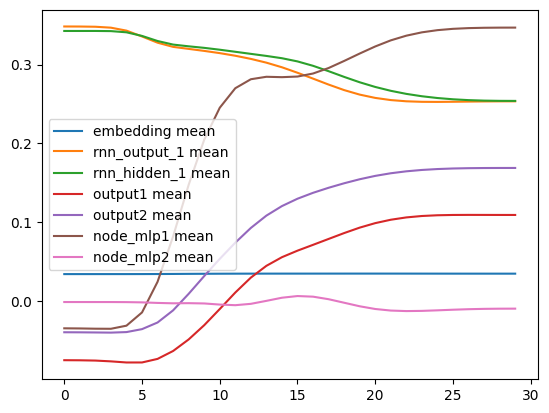

In [9]:
# figsize = 100
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

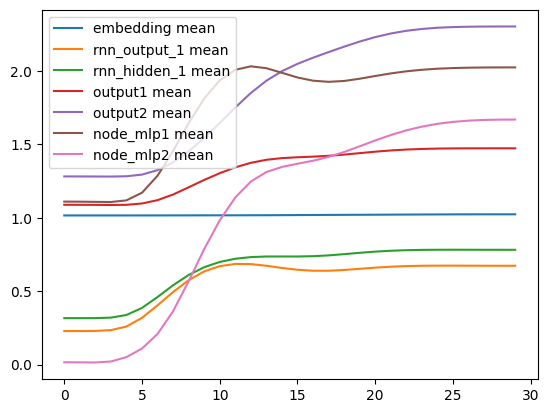

In [13]:
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

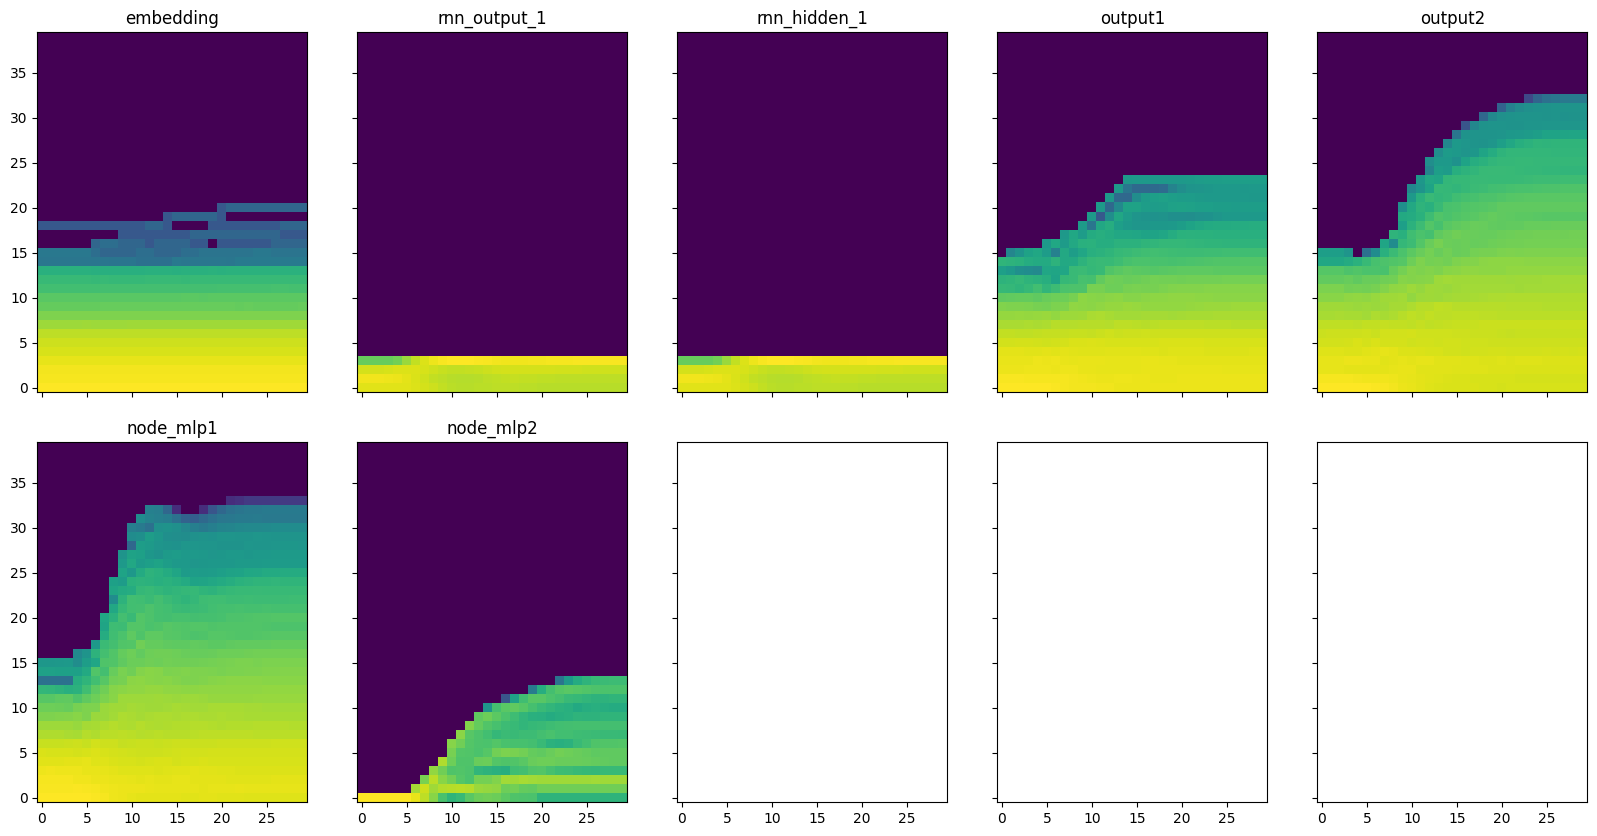

In [14]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): 
    return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_rnn.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_rnn[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

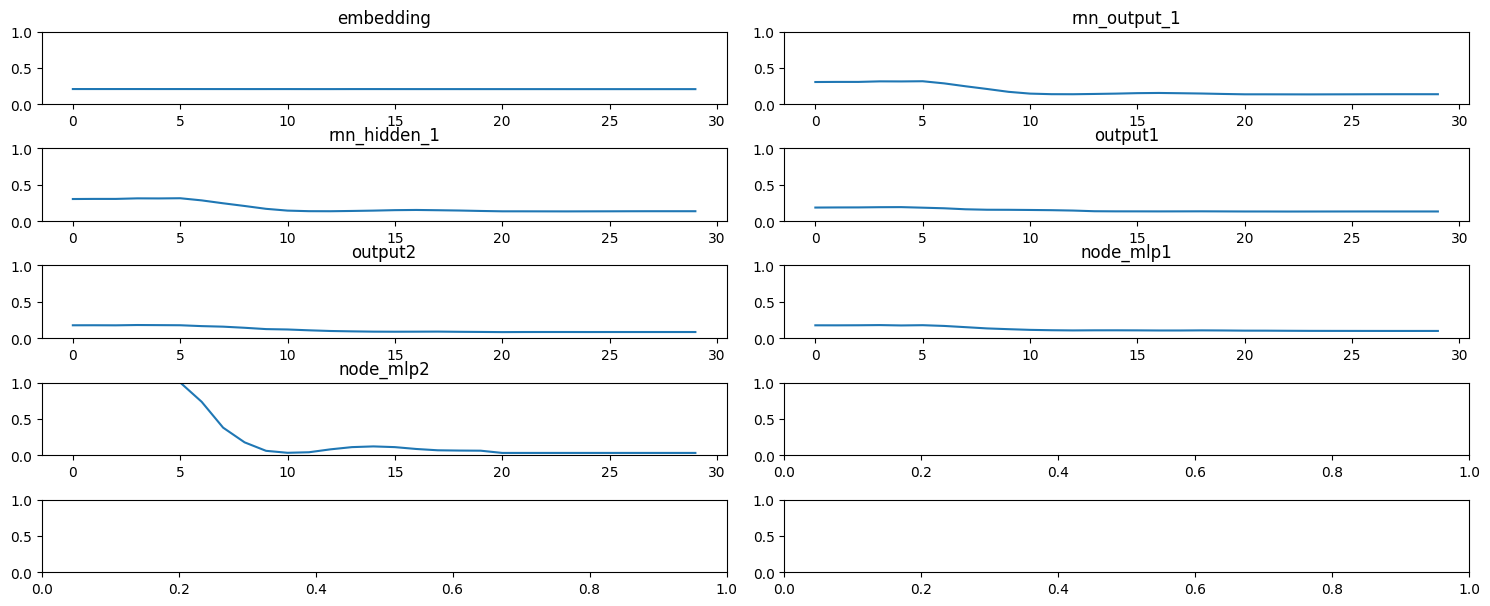

In [15]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(5,2, figsize=(15, 6))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_rnn.keys())):
    h = layer_hists_rnn[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)